# Measuring Influence on Instagram: A Network-Oblivious Approach
## by Segev et al.

##### Reproduced by Florentin Huemer, Fraenzi Mueller, Naida Dzigal

In [3]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge, LinearRegression
from scipy.stats import zscore
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from scipy.stats import spearmanr
from sklearn.cluster import KMeans

## Load Datasets

Download data from https://klear.com/sigir/instagram_data.zip

In [4]:
path_u = os.path.abspath("usersData.csv")
path_f = os.path.abspath("followers_views.csv")
path_l = os.path.abspath("likes_views.csv")
user = pd.read_csv(path_u)
follower = pd.read_csv(path_f)
likes = pd.read_csv(path_l)
del path_u, path_f, path_l

The number of followers seem to suggest that the first 8 entries represent the posts made by the first user in the user dataframe.
However, when calculating the average views they do not match up.

In [6]:
print("Avg views of the first user from the \nuser df: 333.1667 \nfrom the follower df: {}".format(follower.loc[:7,'views'].mean()))
follower.head(9)

Avg views of the first user from the 
user df: 333.1667 
from the follower df: 372.875


,followers,views
0,13178,250
1,13178,604
2,13178,239
3,13178,858
4,13178,271
5,13178,317
6,13178,318
7,13178,126
8,4228,372


Furthermore, the followers csv file and the likes csv file have a different number of entries.

In [7]:
print(follower.shape)
print(likes.shape)
likes.head()

(1422894, 2)
(1426188, 2)


,likes,views
0,98,250
1,100,604
2,109,239
3,103,858
4,106,271


## Plot Figures

#### Distributions per Instagrammer

The graphs look very similar to the originals, however, the average views are off by 3.

Mean views: 745.0688204134606 (paper: 748)


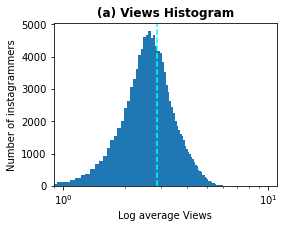

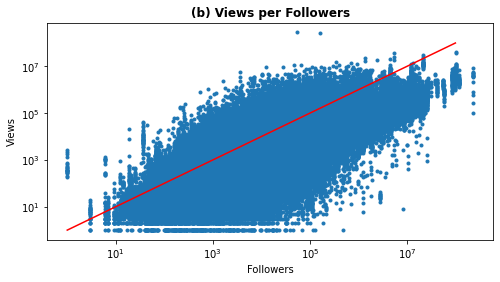

Text(0, 0.5, 'Views')

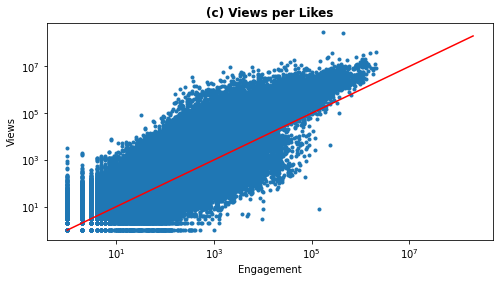

In [11]:
#figure (a)
views_log = np.log10(user["avg_views"])
print("Mean views: {} (paper: 748)".format(10**(views_log.mean())))
plt.figure(figsize=[4,3])
plt.hist(views_log,bins=100)
plt.axvline(x=views_log.mean(),linestyle='--',color='cyan')
plt.xscale("log")
plt.xlim(left=0.9,right=11)
plt.xlabel("Log average Views")
plt.ylabel("Number of instagrammers")
plt.title("(a) Views Histogram", fontweight="bold")
plt.show()

#figure (b)
plt.figure(figsize=(8,4))
plt.plot(follower["followers"],follower["views"],".")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Followers")
plt.ylabel("Views")
plt.plot([1,10**8],[1,10**8],"r-")
plt.title("(b) Views per Followers", fontweight="bold")
plt.show()

#figure (c)
plt.figure(figsize=(8,4))
plt.plot(likes["likes"],likes["views"],".")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Engagement")
plt.plot([1,2*10**8],[1,2*10**8],"r-")
plt.title("(c) Views per Likes", fontweight="bold")
plt.ylabel("Views")

#https://stackoverflow.com/questions/46415327/matplotlib-plot-points-look-fuzzy-in-python-sharp-in-ipython

Figure (a) shows that this statistic behaves in a log-normal distribution as statet in the paper as well.

#### Transform "likes" and "followers" using log scale , drop inf 


In [8]:
user_scaled = user.copy()
user_scaled.loc(1)["avg_likes"] = user["avg_likes"] / np.log(user["avg_likes"])
user_scaled.loc(1)["avg_followers"] = user["avg_followers"] / np.log(user["avg_followers"])
user_scaled = user_scaled.loc[user_scaled["avg_likes"] != np.inf,:]

x_full, y_full = user_scaled.drop("avg_views",1), user_scaled["avg_views"]

## Remove Outliers

From the paper: "To avoid these sorts of odd behaviors, we performed univariate
outliers removal, ignoring the top and bottom posts for users with
posts statistics above 2 standard deviations." Since it was not clear how to link the like and follower dataset (which presumably include the posts of each user) to the user dataset we could not perform outlier removal

Since "cross_val_score" does not include the spearman correlation coefficient; a custom scorer has to be implemented.

In [9]:
def spearman_function(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]
spearman_scorer = make_scorer(spearman_function)

## Add Features

In [12]:
user["likes*followers"] = np.sqrt(user['avg_likes']*user["avg_followers"])
user["followers/post"] = user["avg_followers"] / user["avg_posts"]
user["comments/likes"] = user["avg_comments"] / user["avg_likes"]
user["focus dif"] = user["max_likes"] - user["min_likes"]
user["focus ratio"] = user["max_likes"] / user["min_likes"]
print(user.shape)
user.head()

(114781, 12)


,avg_likes,avg_comments,avg_followers,avg_posts,max_likes,min_likes,avg_views,likes*followers,followers/post,comments/likes,focus dif,focus ratio
0,97.50,3.00,13178.0,1967.0,113,59,333.1667,1133.514446,6.699542,0.030769,54,1.915254
1,91.75,9.25,4228.0,1402.0,174,39,308.6250,622.831438,3.015692,0.100817,135,4.461538
2,33.00,3.50,2212.0,2471.0,46,23,126.7500,270.177719,0.895184,0.106061,23,2.000000
3,20.00,3.50,203.0,1838.0,26,16,65.5000,63.718129,0.110446,0.175000,10,1.625000
4,13.20,1.20,132.0,309.0,18,9,61.2000,41.742065,0.427184,0.090909,9,2.000000


## Regression models (R<sup>2</sup> and r<sub>s</sub> statistics)

The target attribute "Influence of Instagrammer" is defined as the mean (or average) views per Instagrammer.

#### Baselines

Cross validation gets repreated 100 times.

In [46]:
lin = LinearRegression()
cv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=1)

#follower baseline
n_scores = cross_val_score(lin, user_scaled["avg_followers"].values.reshape(-1, 1), y_full, scoring='r2', cv=cv, n_jobs=-1)
print('R2 follower baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

n_scores = cross_val_score(lin, user_scaled["avg_followers"].values.reshape(-1, 1), y_full, scoring=spearman_scorer, cv=cv, n_jobs=-1)
print('rs follower baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

#like baseline
n_scores = cross_val_score(lin, user_scaled["avg_likes"].values.reshape(-1, 1), y_full, scoring='r2', cv=cv, n_jobs=-1)
print('R2 like baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

n_scores = cross_val_score(lin, user_scaled["avg_likes"].values.reshape(-1, 1), y_full, scoring=spearman_scorer, cv=cv, n_jobs=-1)
print('rs like baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

R2 follower baseline: 0.260 (0.241)
rs follower baseline: 0.753 (0.003)
R2 like baseline: 0.683 (0.109)
rs like baseline: 0.845 (0.002)


#### Random forest

"full"

Due to time constraints random forest cv is only run once.

In [10]:
cv_f = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
forest = RandomForestRegressor()

scores = cross_val_score(forest, x_full, y_full, scoring='r2', cv=cv_f)
print("R2 forest score: {} ({})".format(scores.mean(),scores.std()))

scores = cross_val_score(forest, x_full, y_full, scoring=spearman_scorer, cv=cv_f)
print("rs forest score: {} ({})".format(scores.mean(),scores.std()))

R2 forest score: 0.6262253419495358 (0.13575505132607982)
rs forest score: 0.868902030133445 (0.001816374164678161)


"minimal"

In [10]:
rfe_f = RFECV(estimator=RandomForestRegressor())
forest = RandomForestRegressor()

pipeline_forest = Pipeline(steps=[('feature selection',rfe_f),('model',forest)])

cv_f = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
n_scores = cross_val_score(pipeline_forest, x_full, y_full, scoring='r2', cv=cv_f, n_jobs=None)

print('R2 Randomforest reduced: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

R2 Randomforest reduced: 0.611 (0.117)


In [11]:
n_scores = cross_val_score(pipeline_forest, x_full, y_full, scoring=spearman_scorer, cv=cv_f, n_jobs=None)

print('rs Randomforest reduced: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

rs Randomforest reduced: 0.864 (0.008)


#### Ridge

"full"

Again cv is run 100 times.

In [22]:
ridge = Ridge()
cv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=1)
scores = cross_val_score(ridge, x_full, y_full, scoring='r2', cv=cv)
print('R2 Ridge: %.3f (%.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(ridge, x_full, y_full, scoring=spearman_scorer, cv=cv)
print('rs Ridge: %.3f (%.3f)' % (scores.mean(), scores.std()))

R2 Ridge: 0.677 (0.158)
rs Ridge: 0.816 (0.009)


"minimal"

In [51]:
rfe_r = RFECV(estimator=Ridge())
ridge = Ridge()
pipeline_ridge = Pipeline(steps=[('feature selection',rfe_r),('model',ridge)])

n_scores = cross_val_score(pipeline_ridge, x_full, y_full, scoring='r2', cv=cv, n_jobs=None)
print('R2 Ridge reduced: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

n_scores = cross_val_score(pipeline_ridge, x_full, y_full, scoring=spearman_scorer, cv=cv, n_jobs=None)
print('rs Ridge reduced: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

R2 Ridge reduced: 0.671 (0.129)
rs Ridge reduced: 0.838 (0.009)


### Multiple Regression

#### Clustering with different k values

In [10]:
def plot_kmeans(kmeans):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.scatter(user_scaled['avg_followers'], user_scaled['avg_views'], c=kmeans.labels_)
    plt.xscale("log")
    plt.yscale("log")
    
    plt.xlabel("avg followers")
    ax1.set_title("followers and views from the user dataframe, normal scale")
    ax2.scatter(user_scaled['avg_followers'], user_scaled['avg_views'], c=kmeans.labels_)
    plt.xlabel("avg followers")
    plt.ylabel("Views")
    plt.title("log scale")

    print("Cluster sizes: {}".format(np.unique(kmeans.labels_,return_counts=True)[1]))
    plt.show()

Cluster sizes: [114769      8]


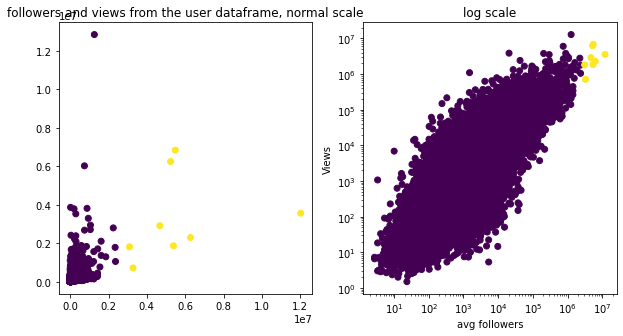

In [11]:
kmeans2 = KMeans(n_clusters=2, random_state=0, n_init=100).fit(user_scaled['avg_followers'].values.reshape(-1, 1))
plot_kmeans(kmeans2)

Cluster sizes: [114666    105      6]


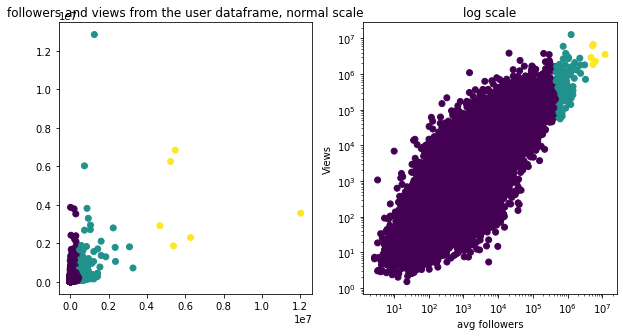

In [12]:
kmeans3 = KMeans(n_clusters=3, random_state=0, n_init=100).fit(user_scaled['avg_followers'].values.reshape(-1, 1))
plot_kmeans(kmeans3)

Cluster sizes: [114642      7    127      1]


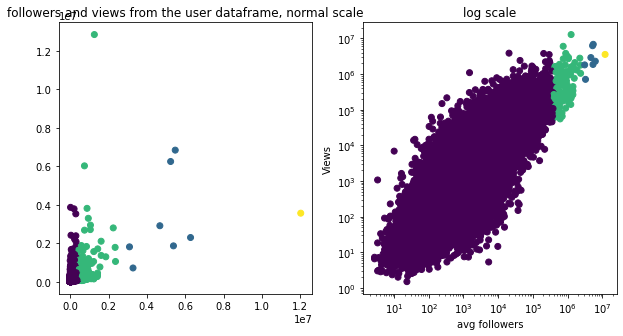

In [13]:
kmeans4 = KMeans(n_clusters=4, random_state=0, n_init=100).fit(user_scaled['avg_followers'].values.reshape(-1, 1))
plot_kmeans(kmeans4)

Cluster sizes: [114372      7     55      1    342]


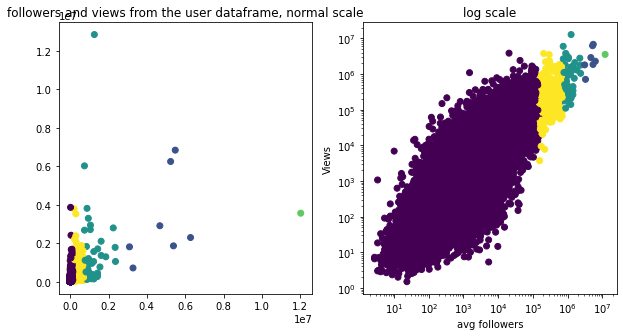

In [14]:
kmeans5 = KMeans(n_clusters=5, random_state=0,n_init=100).fit(user_scaled['avg_followers'].values.reshape(-1, 1))
plot_kmeans(kmeans5)


Only clusters with k=2 or k=3 have enough data in the smallest group to do 5-fold CV. Since the goal of the clustering is to use regession on celebrities seperatly, the first plot (k=2) seems to make the most sense. 

In [15]:
normal_users = user_scaled.iloc[( kmeans2.labels_ == 0 ),: ].copy()
celebrities =  user_scaled.iloc[( kmeans2.labels_ == 1 ),: ].copy()
x_normal,y_normal = normal_users.drop("avg_views",1), normal_users["avg_views"]

#### Baselines

In [61]:
lin = LinearRegression()

#follower baseline
n_scores = cross_val_score(lin, normal_users["avg_followers"].values.reshape(-1, 1), normal_users['avg_views'], scoring='r2', cv=cv, n_jobs=-1)
print('Normal R2 follower baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

n_scores = cross_val_score(lin, celebrities["avg_followers"].values.reshape(-1, 1), celebrities['avg_views'], scoring='r2', cv=cv, n_jobs=-1)
print('celebrities R2 follower baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

n_scores = cross_val_score(lin, normal_users["avg_followers"].values.reshape(-1, 1), normal_users['avg_views'], scoring=spearman_scorer, cv=cv, n_jobs=-1)
print('Normal rs follower baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

n_scores = cross_val_score(lin, celebrities["avg_followers"].values.reshape(-1, 1), celebrities['avg_views'], scoring=spearman_scorer, cv=cv, n_jobs=-1)
print('celebrities rs follower baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

print("----------")
#like baseline
n_scores = cross_val_score(lin, normal_users["avg_likes"].values.reshape(-1, 1), normal_users['avg_views'], scoring='r2', cv=cv, n_jobs=-1)
print('Nomal R2 like baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

n_scores = cross_val_score(lin, celebrities["avg_likes"].values.reshape(-1, 1), celebrities['avg_views'], scoring='r2', cv=cv, n_jobs=-1)
print('celebrities R2 like baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

n_scores = cross_val_score(lin, normal_users["avg_likes"].values.reshape(-1, 1), normal_users['avg_views'], scoring=spearman_scorer, cv=cv, n_jobs=-1)
print('Nomal rs like baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

n_scores = cross_val_score(lin, celebrities["avg_likes"].values.reshape(-1, 1), celebrities['avg_views'], scoring=spearman_scorer, cv=cv, n_jobs=-1)
print('celebrities rs like baseline: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

Normal R2 follower baseline: 0.283 (0.084)
celebrities R2 follower baseline: nan (nan)
Normal rs follower baseline: 0.753 (0.003)
celebrities rs follower baseline: nan (nan)
----------
Nomal R2 like baseline: 0.625 (0.160)
celebrities R2 like baseline: nan (nan)
Nomal rs like baseline: 0.845 (0.002)
celebrities rs like baseline: nan (nan)


The celebrity cluster does not work as there is to little data when cross validation is appiled. From now on only normal users will be used and the K-means clustering will be treated as a form of outlier removal. 

#### Random Forest

"full"

In [25]:
n_scores = cross_val_score(forest, x_normal, y_normal, scoring='r2', cv=cv_f, n_jobs=None)
print('R2 Randomforest full: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

R2 Randomforest full: 0.702 (0.117)


In [26]:
n_scores = cross_val_score(forest, x_normal, y_normal, scoring=spearman_scorer, cv=cv_f, n_jobs=None)
print('rs Randomforest full: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

rs Randomforest full: 0.868 (0.002)


"minimal"

In [27]:
n_scores = cross_val_score(pipeline_forest, x_normal, y_normal, scoring='r2', cv=cv_f, n_jobs=None)
print('R2 Randomforest reduced: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

R2 Randomforest reduced: 0.711 (0.107)


In [20]:
cv_f = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
rfe_f = RFECV(estimator=RandomForestRegressor())
forest = RandomForestRegressor()

pipeline_forest = Pipeline(steps=[('feature selection',rfe_f),('model',forest)])

n_scores = cross_val_score(pipeline_forest, x_normal, y_normal, scoring=spearman_scorer, cv=cv_f, n_jobs=-1)
print('rs Randomforest reduced: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

rs Randomforest reduced: 0.868 (0.003)


#### Ridge Regression

"full"

In [23]:
n_scores = cross_val_score(ridge, x_normal, y_normal, scoring='r2', cv=cv, n_jobs=None)
print('R2 Ridge full: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

n_scores = cross_val_score(ridge, x_normal, y_normal, scoring=spearman_scorer, cv=cv, n_jobs=None)
print('rs Ridge full: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

R2 Ridge full: 0.584 (0.213)
rs Ridge full: 0.823 (0.014)


"minimal"

In [23]:
rfe_r = RFECV(estimator=Ridge())
ridge = Ridge()
pipeline_ridge = Pipeline(steps=[('feature selection',rfe_r),('model',ridge)])
cv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=1)
n_scores = cross_val_score(pipeline_ridge, x_normal, y_normal, scoring='r2', cv=cv, n_jobs=None)
print('R2 Ridge reduced: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

n_scores = cross_val_score(pipeline_ridge, x_normal, y_normal, scoring=spearman_scorer, cv=cv, n_jobs=None)
print('rs Ridge reduced: %.3f (%.3f)' % (n_scores.mean(), n_scores.std()))

R2 Ridge reduced: 0.600 (0.193)
rs Ridge reduced: 0.837 (0.006)


## Significane Testing

### P values

In [5]:
from scipy.stats import t
from scipy.stats import norm


import math

For random forest we used a 2 tailed T-test as the sample size was much lower, for everything else we used a 2 talied Z-test. The missing sample standard deviation for the results listed in the paper forced us to use this approach. 

In [21]:
def p_val(samp_mean,pop_mean,samp_std,n,use_t_dist=True):
    normalized = (samp_mean - pop_mean)*math.sqrt(n)/samp_std
    if use_t_dist:
        p = (1 - t.cdf(x=normalized, df=n-1)) * 2
    else:
        p = norm.sf(abs(normalized))*2
    return p

#### Random forest

In [20]:
print("P values for:")
print("RF full R2: same score rs same score".format(p_val(0.626,0.626,0.136,5)))
print("RF min: R2: {:.3f} rs same score".format(p_val(0.611,0.616,0.117,5)))
print("RF full multi R2: {:.3f} rs: {:.3f}".format(p_val(0.702,0.621,0.117,5),p_val(0.868,0.861,0.002,5)))
print("RF min multi: R2: {:.3f} rs: {:.3f}".format(p_val(0.711,0.611,0.107,5),p_val(0.868,0.859,0.003,5)))


RF full R2: same score rs same score
RF min: R2: 1.072 rs same score
RF full multi R2: 0.182 rs: 0.001
RF min multi: R2: 0.091 rs: 0.001


#### Ridge regression

In [31]:
print("P values for:")
print("Ridge full R2: {} rs: {}".format(p_val(0.677,0.725,0.158,n=500,use_t_dist=False),p_val(0.816,0.848,0.009,n=500,use_t_dist=False)))
print("Ridge min R2: {} rs: {}".format(p_val(0.671,0.723,0.129,n=500,use_t_dist=False),p_val(0.838,0.818,0.009,n=500,use_t_dist=False)))
print("Ridge full multi R2: {} rs: {:.6f}".format(p_val(0.671,0.723,0.129,n=500,use_t_dist=False),p_val(0.823,0.821,0.014,n=500,use_t_dist=False)))
print("Ridge min multi R2: {} rs: {}".format(p_val(0.671,0.723,0.129,n=500,use_t_dist=False),p_val(0.837,0.818,0.006,n=500,use_t_dist=False)))

P values for:
Ridge full R2: 1.0973562155380842e-11 rs: 0.0
Ridge min R2: 1.9938759275140052e-19 rs: 0.0
Ridge full multi R2: 1.9938759275140052e-19 rs: 0.001401
Ridge min multi R2: 1.9938759275140052e-19 rs: 0.0


#### Baselines

In [33]:
print("P values for:")
print("Follower R2: {} rs: {}".format(p_val(0.260,0.211,0.241,n=500,use_t_dist=False),p_val(0.753,0.757,0.003,n=500,use_t_dist=False)))
print("Follower multi R2: {} rs: {}".format(p_val(0.283,0.204,0.084,n=500,use_t_dist=False),p_val(0.753,0.725,0.002,n=500,use_t_dist=False)))

print("Likes R2: {} rs: {}".format(p_val(0.683,0.666,0.109,n=500,use_t_dist=False),p_val(0.845,0.859,0.002,n=500,use_t_dist=False)))
print("Likes multi R2: {} rs: {}".format(p_val(0.625,0.654,0.160,n=500,use_t_dist=False),p_val(0.845,0.853,0.002,n=500,use_t_dist=False)))

P values for:
Follower R2: 5.458105629740305e-06 rs: 2.554226304941737e-195
Follower multi R2: 3.5095853993457027e-98 rs: 0.0
Likes R2: 0.0004876583570573577 rs: 0.0
Likes multi R2: 5.059242467799053e-05 rs: 0.0
